In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Tide gauge data from Nain, Nunatsiavut; 1963-2018; hourly intervals; access here: http://uhslc.soest.hawaii.edu/data/?rq#uh833a

The observed gauge height (var = "height") has been corrected for the mean height of the entire record, which is 1431 mm (var = "h_mean_corr").

The observation record has many data gaps. All of the sections of the record for which there are at least 365 consecutive days of data (n=10) have been extracted and combined into the file 'year_long_gauge_records_Nain.csv'. Only the first 365 days of each of these sections has been obtained, such that each of the 10 periods of observation span the same length of time. **The value in 'Section ID' corresponds to a unique year-long observation record**

Here, the data file is loaded and the first few lines are displayed:

In [2]:
Nain_gauge = pd.read_csv('year_long_gauge_records_Nain.csv')
Nain_gauge.head()

,Unnamed: 0,index,year,month,day,hour,height,datetime,h_mean_corr,Section ID
0,0,16896,1965,9,20,5,1500.0,1965-09-20 05:00:00,68.848582,0
1,1,16897,1965,9,20,6,1670.0,1965-09-20 06:00:00,238.848582,0
2,2,16898,1965,9,20,7,1770.0,1965-09-20 07:00:00,338.848582,0
3,3,16899,1965,9,20,8,1780.0,1965-09-20 08:00:00,348.848582,0
4,4,16900,1965,9,20,9,1680.0,1965-09-20 09:00:00,248.848582,0


Here, a function is defined that applies a Doodson filter to an array, which isolates the non-tidal component:

In [3]:
def DoodsonX0(ts):
    '''
    Running Avgerage on data of using Doodson X0 filter.
    Filter weights are designed to remove the main tidal
    consituents of hourly data. Filter is 39 points long
    and so both the first and last 19 points of 'avg' are
    made into NaNs.

    Filter found here: http://www.pol.ac.uk/ntslf/acclaimdata/gloup/doodson_X0.html

    Adapted from MATLAB code by Eric Oliver, 14 Aug 2019
    '''
    X0 = np.array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 1, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1])/30.
    ts_smooth = np.convolve(ts, X0, mode='same')
    return ts_smooth

The groupby function is applied to the DataFrame, which splits the DataFrame into groups based on the value in the 'Section ID' column:

In [4]:
grouped = Nain_gauge.groupby('Section ID')

The results of the 'groupby' function for one column are displayed:

In [17]:
grouped['height'].describe()

,count,mean,std,min,25%,50%,75%,max
Section ID,,,,,,,,
0,8760.0,1531.743151,602.190002,-70.0,1050.00,1520.0,2010.00,3100.0
1,8760.0,1443.004566,596.607768,-330.0,970.00,1435.0,1910.00,3190.0
2,8760.0,1467.789954,590.079943,-40.0,1000.00,1460.0,1940.00,3210.0
3,8760.0,1466.547945,592.669284,60.0,990.00,1465.0,1930.00,3410.0
4,8760.0,1427.172374,602.210121,-230.0,950.00,1420.0,1900.00,3130.0
5,8760.0,1405.237557,603.849043,-180.0,920.00,1390.0,1880.00,3210.0
6,8760.0,1339.143721,616.041610,-120.0,828.00,1327.0,1828.00,2935.0
7,8760.0,1373.355594,624.420881,-84.0,864.75,1368.0,1871.00,3003.0
8,8760.0,1375.266438,621.340892,-234.0,864.00,1366.0,1868.00,3077.0


To apply the DoodsonX0 function, the values stored in the DataFrame must be stored in an array. 

In [59]:
heights = grouped['h_mean_corr'].apply(lambda x: x.values.tolist())

The Doodson function is applied:

In [60]:
h_Nt = heights.apply(DoodsonX0)

The result is visualized:

(P.S. I independently checked this was working, but am uploading a cleaned version of the notebook)

In [61]:
h_Nt

Section ID
0    [59.75762409130945, 59.34752952570625, 62.9758...
1    [-106.57570924202388, -107.98580380762706, -11...
2    [-12.909042575357194, -19.31913714096039, -12....
3    [-20.575709242023883, -13.319137140960382, -6....
4    [1.0909574246428022, -21.652470474293715, -13....
5    [107.09095742464278, 143.34752952570628, 157.9...
6    [11.757624091309436, 34.147529525706254, 37.27...
7    [68.42429075797611, 56.21419619237292, 65.0424...
8    [29.257624091309452, 39.280862859039594, 42.74...
9    [14.390957424642814, 1.014196192372971, 13.242...
Name: h_mean_corr, dtype: object

This code turns the list of values into a long list:

In [62]:
h_Nt =  h_Nt.explode().tolist()

And the results of the Doodson function are added to the original DataFrame as variable 'h_Nt':

In [63]:
Nain_gauge['h_Nt'] = h_Nt

The tidal components are calculated:

$ height_{tides} = height_{observed} - height_{non-tidal}$

And stored in the original DataFrame as variable 'h_T':

In [65]:
Nain_gauge['h_T'] = Nain_gauge['h_mean_corr'] - Nain_gauge['h_Nt']

A boxplot of the tidal component overtime is displayed:

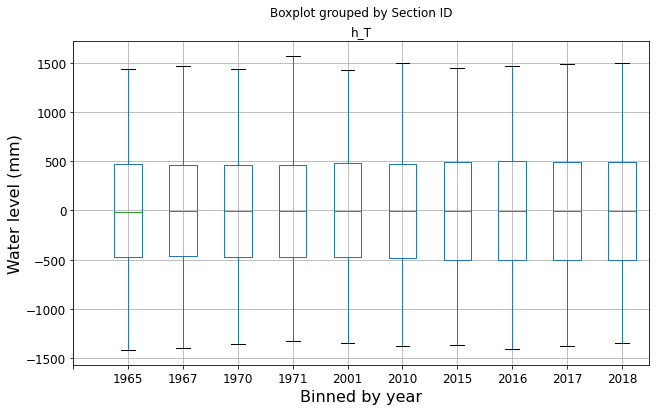

In [66]:
ax = Nain_gauge.boxplot(column='h_T',by='Section ID', figsize=(10,6), fontsize=12)
ax.set_ylabel('Water level (mm)', fontsize=16)
ax.set_xlabel('Binned by year', fontsize=16)
ax.set_xticks(np.arange(11), 
           labels=('','1965', '1967', '1970', '1971', '2001', '2010', '2015', '2016', '2017', '2018'))

plt.show()

And the summary statistics for the tidal component are displayed:

In [67]:
grouped['h_T'].describe()

,count,mean,std,min,25%,50%,75%,max
Section ID,,,,,,,,
0,8760.0,0.107899,587.580296,-1420.333333,-478.666667,-11.500000,468.416667,1442.000000
1,8760.0,-0.186203,576.146799,-1398.000000,-467.333333,-10.833333,460.666667,1470.333333
2,8760.0,-0.091720,576.694920,-1361.666667,-471.000000,-11.166667,463.666667,1437.000000
3,8760.0,-0.022428,576.988169,-1323.000000,-469.000000,-6.666667,458.416667,1574.666667
4,8760.0,-0.151956,584.419601,-1352.000000,-478.083333,-10.500000,477.000000,1424.000000
5,8760.0,0.111400,589.409220,-1377.333333,-482.333333,-10.833333,473.416667,1502.000000
6,8760.0,-0.072241,602.512189,-1366.433333,-501.475000,-6.533333,496.150000,1449.666667
7,8760.0,0.054342,608.201534,-1412.000000,-509.391667,-6.116667,499.200000,1472.966667
8,8760.0,0.163386,605.801504,-1378.966667,-501.350000,-9.566667,496.341667,1490.300000


Same displays, but for the non-tidal component:

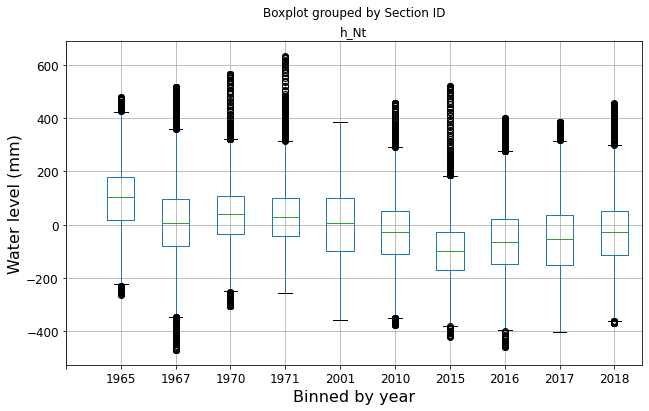

In [68]:
ax = Nain_gauge.boxplot(column='h_Nt',by='Section ID', figsize=(10,6), fontsize=12)
ax.set_ylabel('Water level (mm)', fontsize=16)
ax.set_xlabel('Binned by year', fontsize=16)
ax.set_xticks(np.arange(11), 
           labels=('','1965', '1967', '1970', '1971', '2001', '2010', '2015', '2016', '2017', '2018'))

plt.show()

In [69]:
grouped['h_Nt'].describe()

,count,mean,std,min,25%,50%,75%,max
Section ID,,,,,,,,
0,8760.0,100.483833,126.214158,-264.484752,16.848582,101.848582,179.848582,480.181915
1,8760.0,12.039350,147.144015,-472.484752,-82.151418,4.515248,94.848582,519.181915
2,8760.0,36.730256,117.905718,-306.818085,-36.818085,38.181915,106.515248,568.515248
3,8760.0,35.418955,125.865386,-259.484752,-44.151418,26.848582,99.848582,636.181915
4,8760.0,-3.827088,138.816541,-358.818085,-100.151418,4.848582,98.515248,386.848582
5,8760.0,-26.025262,125.179988,-378.484752,-110.484752,-27.484752,50.181915,458.848582
6,8760.0,-91.935456,120.952519,-423.651418,-169.484752,-98.384752,-27.976418,520.081915
7,8760.0,-57.850166,134.099834,-460.984752,-146.984752,-66.934752,22.115248,400.215248
8,8760.0,-56.048367,132.072734,-403.418085,-150.909752,-53.568085,36.165248,385.948582
